In [6]:
import pandas as pd
import datetime
import numpy as np
import matplotlib as plt
import stock_utils as su
import pylab as pl

from sklearn.linear_model import Ridge, LinearRegression, SGDRegressor, ElasticNet, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

%matplotlib inline

## Choose a ticker symbol and generate a dataset with selected new features for it

In [27]:
#create a dataset for AAPL
rs = 42 # random state
tickers = ['AAPL', 'MSFT', 'GOOG']
symbol = tickers[0]
window = 5
look_ahead = 1
start_date = datetime.datetime(2016, 1, 1)
end_date = datetime.datetime(2016, 12, 31)

dataset = su.preprocess_data(symbol, window, look_ahead, start_date, end_date)

data = dataset.drop(labels=['Future Price'], axis=1)
target = dataset['Future Price']

dataset.head()

,Open,High,Low,Close,Daily return,Rolling mean 5,Lower Bollinger band 5,Upper Bollinger band 5,Cummulative return 5,Future Price
2016-01-06,100.56,102.37,99.87,100.70,-0.019570,103.892,108.130311,99.653689,-0.044139,96.45
2016-01-07,98.68,100.13,96.43,96.45,-0.042205,102.112,109.553699,94.670301,-0.084480,96.96
2016-01-08,98.55,99.11,96.76,96.96,0.005288,100.434,108.007567,92.860433,-0.079639,96.96
2016-01-09,98.55,99.11,96.76,96.96,0.000000,98.756,104.340095,93.171905,-0.079639,96.96
2016-01-10,98.55,99.11,96.76,96.96,0.000000,97.606,101.093280,94.118720,-0.055983,98.53


## Find hyperparameters for model

In [19]:
def cross_val_splits(X, n_splits=5):
    splits = TimeSeriesSplit(n_splits)
    cv_splits = []

    for train_index, test_index in splits.split(X):
        cv_splits.append((train_index, test_index))

    return cv_splits

In [31]:
lasso = Lasso(random_state=rs)
lasso_params = {'reg__alpha' : [0.00001, 0.0001, 0.001, 0.01, 0.1], 'reg__max_iter' : [1000, 10000, 100000, 1000000]}

ridge = Ridge(random_state=rs)
ridge_params = {'reg__alpha' : [10, 1, 0.1, 0.01, 0.001, 0.0001]}

elasticnet = ElasticNet(random_state=rs)
elasticnet_params = {'reg__alpha' : [10, 1, 0.1, 0.001, 0.0001], 'reg__l1_ratio' : [0.1, 0.3, 0.5, 0.9]}

lin_reg = LinearRegression()

models_params = [(lasso, lasso_params), (ridge, ridge_params), (elasticnet, elasticnet_params), (lin_reg, {})]

scores = []
estimators = []

for model, params in models_params:
    class_name = model.__class__.__name__
    
    print ("\n{0}: \n".format(class_name))

    steps = [('scaler', StandardScaler()), ('reg', model)]
    pipe = Pipeline(steps)

    cv_splits = cross_val_splits(data, n_splits = 5)
    grid_search = GridSearchCV(pipe, params, cv = cv_splits)

    grid_search.fit(data, target)

    best_params = grid_search.best_params_
    print('best parameters: {0}'.format(best_params))

    best_score = grid_search.best_score_
    print('best score: {0}'.format(best_score))
    
    scores.append(best_score)

    best_estimator = grid_search.best_estimator_
    estimators.append(best_estimator)


Lasso: 

best parameters: {'reg__max_iter': 10000, 'reg__alpha': 1e-05}
best score: 0.870653572838

Ridge: 

best parameters: {'reg__alpha': 0.0001}
best score: 0.870653691351

ElasticNet: 

best parameters: {'reg__l1_ratio': 0.1, 'reg__alpha': 0.001}
best score: 0.870715750694

LinearRegression: 

best parameters: {}
best score: 0.870653829683


## Generate training and testing datasets

In [149]:
data = dataset.drop(labels=['UpDown', 'Future Price'], axis=1)
target = dataset['Future Price']
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=42)

print ('Training set has {0} samples.'.format(X_train.shape[0]))
print ('Testing set has {0} samples.'.format(X_test.shape[0]))

Training set has 252 samples.
Testing set has 108 samples.


In [150]:
def plot_predictions(title, y, y_hat):
    pl.title(title)
    pl.plot(y, y_hat, 'ro')
    pl.plot([np.amin(y), np.amax(y)],[np.amin(y_hat), np.amax(y_hat)], 'g-')
    pl.xlabel('Real values')
    pl.ylabel('Predicted values')
    pl.show()

In [151]:
def print_cross_val_accuracy(est, X, y):
    scores = cross_val_score(pip, X, y)
    print('cross validation accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))


RandomForestRegressor: 

score for training set: 0.994028919171
cross validation accuracy: 0.93 (+/- 0.01)
score for test set: 0.969286588262
cross validation accuracy: 0.97 (+/- 0.02)


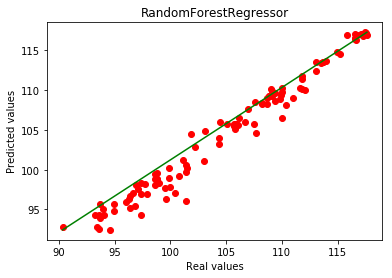


LinearRegression: 

score for training set: 0.972232941585
cross validation accuracy: 0.93 (+/- 0.01)
score for test set: 0.979368878657
cross validation accuracy: 0.97 (+/- 0.02)


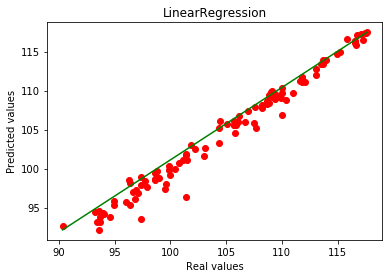


Ridge: 

score for training set: 0.969245747272
cross validation accuracy: 0.93 (+/- 0.01)
score for test set: 0.979311213843
cross validation accuracy: 0.97 (+/- 0.02)


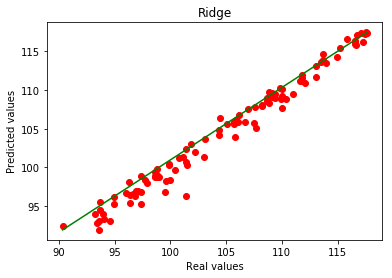


ElasticNet: 

score for training set: 0.90351319373
cross validation accuracy: 0.93 (+/- 0.01)
score for test set: 0.918517834133
cross validation accuracy: 0.97 (+/- 0.02)


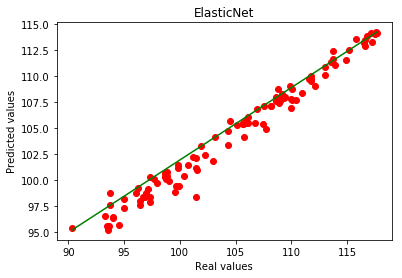

In [152]:
#random state
rs = 42

reg_A = Pipeline([('scaler', StandardScaler()), ('reg', RandomForestRegressor())])

reg_B = Pipeline([('scaler', StandardScaler()), ('reg', LinearRegression(normalize = True))])

reg_C = Pipeline([('scaler', StandardScaler()), ('reg', Ridge (alpha = 0.01, random_state = rs, normalize = True))])
# reg_C_params = {'alpha' : [1, 0.1, 0.01], 'tol' : [0.1, 0.01, 0.001]}
 
reg_D = Pipeline([('scaler', StandardScaler()), ('reg', ElasticNet(alpha = 0.01, random_state = rs, normalize = True))])
# reg_D_params = {'alpha' : [1, 0.1, 0.001], 'l1_ratio' : [0.3, 0.5, 0.8]}

# params = {reg_C.__class__.__name__ : reg_C_params, reg_D.__class__.__name__ : reg_D_params}

for reg in [reg_A, reg_B, reg_C, reg_D]:
    class_name = reg.named_steps['reg'].__class__.__name__
    
    print ("\n{0}: \n".format(class_name))
    
    reg.fit(X_train, y_train)
    
    print('score for training set: {0}'.format(reg.score(X_train, y_train)))
    
    print_cross_val_accuracy(reg, X_train, y_train)

    y_hat_test = reg.predict(X_test)
    print('score for test set: {0}'.format(reg.score(X_test, y_test)))
    
    print_cross_val_accuracy(reg, X_test, y_test)
    
    plot_predictions(class_name, y_test, y_hat_test)

## Generate a validation set and test the prediction accuracy

In [153]:
symbol = tickers[0]
window = 5
look_ahead = 1
valid_start_date = datetime.datetime(2017, 1, 1)
valid_end_date = datetime.datetime(2017, 1, 31)

valid_dataset = su.preprocess_data(symbol, window, look_ahead, valid_start_date, valid_end_date)

valid_dataset.head()

,Close,Daily return,Rolling mean 5,Lower Bollinger band 5,Upper Bollinger band 5,Cummulative return 5,Future Price,UpDown
2017-01-06,117.91,0.011148,116.568,118.134040,115.001960,0.015153,117.91,1
2017-01-07,117.91,0.000000,116.920,118.779892,115.060108,0.015153,117.91,1
2017-01-08,117.91,0.000000,117.272,119.068352,115.475648,0.015153,118.99,1
2017-01-09,118.99,0.009160,117.866,119.553223,116.178777,0.025599,119.11,1
2017-01-10,119.11,0.001008,118.366,119.617687,117.114313,0.021439,119.75,1



RandomForestRegressor: 

score for validation set: -10.5058000389

LinearRegression: 

score for validation set: 0.770353750816

Ridge: 

score for validation set: 0.7206867068

ElasticNet: 

score for validation set: -10.9251949873

r2 score for average predictions: 0.770353750816


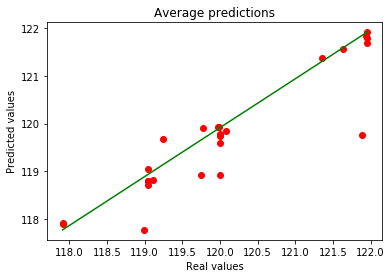

In [154]:
validation_data = valid_dataset.drop(labels=['Future Price'], axis=1)
validation_target = valid_dataset['Future Price']

predictions = []

for reg in [reg_A, reg_B, reg_C, reg_D]:
    class_name = reg.named_steps['reg'].__class__.__name__
    
    print ("\n{0}: \n".format(class_name))
    
    validation_pred = reg.predict(validation_data)
    
    score = reg.score(validation_data, validation_target)
    print('score for validation set: {0}'.format(score))
    
    #we want to keep only usable predictions
    if score > 0.75:
        predictions.append(validation_pred)
#         plot_predictions(class_name, validation_target, validation_pred)
        
average_predictions = np.zeros(validation_target.shape[0])

for p in predictions:
    average_predictions += p

average_predictions /= len(predictions)
    
print('\nr2 score for average predictions: {0}'.format(r2_score(validation_target, average_predictions)))
# print('\nmean squared error for average predictions: {0}'.format(mean_squared_error(validation_target, average_predictions)))

plot_predictions('Average predictions', validation_target, average_predictions)


In [147]:
def up_or_down(x):
    diff = np.roll(x, -1) - x
    ud = [1 if v > 0 else 0 for v in diff]
    return np.array(ud[:-1])

ud_real = up_or_down(validation_target.values)
ud_predicted = up_or_down(average_predictions)

t = np.vstack((ud_real, ud_predicted))
total_predictions = ud_real.shape[0]
correct_predictions = len(np.where(t[0] == t[1])[0])

print('Correct prediction percentage: {0:.2f}'.format((float(correct_predictions) / total_predictions) * 100))

Correct prediction percentage: 62.50
